In [1]:
import os # os stands for "operating system" and includes read/write routines etc. 
import numpy as np # by far the most used library for everyday computation
from scipy import stats # here we import a whole sub-library of stats functions
from scipy.ndimage import gaussian_filter, gaussian_filter1d # here we import a single function
from sklearn.decomposition import PCA # check out all the other dimensionality reduction methods in "decomposition"
from matplotlib import pyplot as plt # all of our plotting is done with plt
%matplotlib inline 

In [2]:
# this function performs a running average filter over the first dimension of X
# (faster than doing gaussian filtering)
def running_average(X, nbin = 100):
    Y = np.cumsum(X, axis=0)
    Y = Y[nbin:, :] - Y[:-nbin, :]
    return Y

# * set root to the location where you downloaded the data *
root      ='/media/maria/DATA1/Documents/data_for_suite2p/'

# LOAD the visual stimuli "mov" and the timings "iframe"
mov    = np.load(os.path.join(root, 'mov.npy')) # these are the visual stimuli shown
iframe = np.load(os.path.join(root, 'iframe.npy')) # iframe[n] is the microscope frame for the image frame n

# LOAD the neural data
spks = np.load(os.path.join(root, 'spks.npy')) # deconvolved data
stat = np.load(os.path.join(root, 'stat.npy'), allow_pickle=True) # these are the per-neuron stats returned by suite2p
# these are the neurons' 2D coordinates
ypos = np.array([stat[n]['med'][0] for n in range(len(stat))]) 
# (notice the python list comprehension [X(n) for n in range(N)])
xpos = np.array([stat[n]['med'][1] for n in range(len(stat))]) 

del stat # we delete stat because we don't need any other fields from it


# align stimuli to spks (since stimuli are triggered by microscope it's easy)
dt = 1 # time offset between stimulus presentation and response
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
mov = mov[:, :, ivalid]
S = spks[:, iframe+dt]
del spks
S = stats.zscore(S, axis=1) # z-score the neural activity before doing anything

proc = np.load(os.path.join(root, 'cam1_TX39_2019_05_31_1_proc_resampled.npy'), allow_pickle=True).item()
motSVD = proc['motSVD'][:,iframe+dt]
parea = proc['pupil']['area'][0][iframe+dt].copy()

In [3]:
# bin data
tbin = 3.0
NT = motSVD.shape[1]
nt = int(np.floor(NT/tbin))
motSVD -= motSVD.mean(axis=1)[:,np.newaxis]
parea  -= np.nanmean(parea)
parea[np.isnan(parea)] = 0
tbin = int(tbin)

beh = np.reshape(motSVD[:,:nt*tbin], (motSVD.shape[0], nt, tbin)).mean(axis=-1)
pup = np.reshape(parea[:nt*tbin], (nt, tbin)).mean(axis=-1)

# using this format bin S
Sbin = np.reshape(S[:,:nt*tbin], (S.shape[0], nt, tbin)).mean(axis=-1)


(18795, 10186)


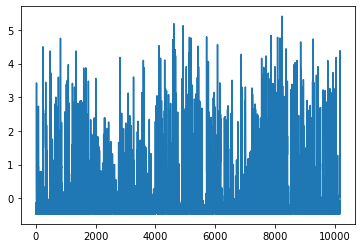

In [4]:
print(Sbin.shape)
plt.plot(Sbin[0,:])

In [5]:
np.save('Sbin.npy',Sbin)

In [6]:
'''
import sys
sys.path.append("..")
from EnsemblePursuitModule.EnsemblePursuitNumpy import EnsemblePursuitNumpy
import numpy as np
import time
options_dict={'seed_neuron_av_nr':100,'min_assembly_size':8}
Sbin=np.load('Sbin.npy')
#ep_pt=EnsemblePursuitNumpy(n_ensembles=300,lambd=0.005,options_dict=options_dict)
ep_pt=EnsemblePursuitNumpy(n_ensembles=20,lambd=0.05,options_dict=options_dict)
start=time.time()
U,V=ep_pt.fit_transform(Sbin)
end=time.time()
np.save('U_binned.npy',U)
np.save('V_binned.npy',V)'''
U=np.load('U_binned.npy')
V=np.load('V_binned.npy')

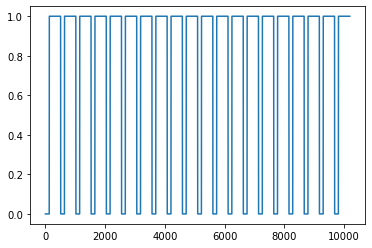

In [7]:

# split into train-test
# * use interleaved segments *
nsegs = 20
nlen  = nt/nsegs
ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
itrain = np.ones(nt, np.bool)
itrain[itest] = 0

plt.plot(itrain)
plt.show()

In [9]:

#### PREDICT USING PUPIL WITH LINEAR REGRESSION
V=V.T
A = np.matmul(pup[itrain], V[:,itrain].T)/(pup**2).sum()

Vpredp = np.matmul(A[:,np.newaxis], pup[itest][np.newaxis,:])

varexp_pupil = 1 - ((Vpredp - V[:,itest])**2).sum(axis=1)/(V[:,itest]**2).sum(axis=1)

#### PREDICT USING BEHAVIOR PC'S 
## regularized linear regression from behavior to neural PCs
covM = np.matmul(beh[:,itrain], beh[:,itrain].T)
lam = 1e5 # regularizer
covM += lam*np.eye(beh.shape[0])
A = np.linalg.solve(covM, np.matmul(beh[:,itrain], V[:,itrain].T))

Vpred = np.matmul(A.T, beh[:,itest])

varexp = 1 - ((Vpred - V[:,itest])**2).sum(axis=1)/(V[:,itest]**2).sum(axis=1)

In [10]:
print(varexp)

[ 0.28688373  0.75164839  0.09244696  0.13026069  0.26454573  0.19060354
  0.03473781  0.27427964  0.12247447  0.27620883  0.07542552  0.07997336
  0.17180883  0.0325569   0.05252863  0.04272352 -0.03653696  0.40201474
  0.14060005  0.53075595]


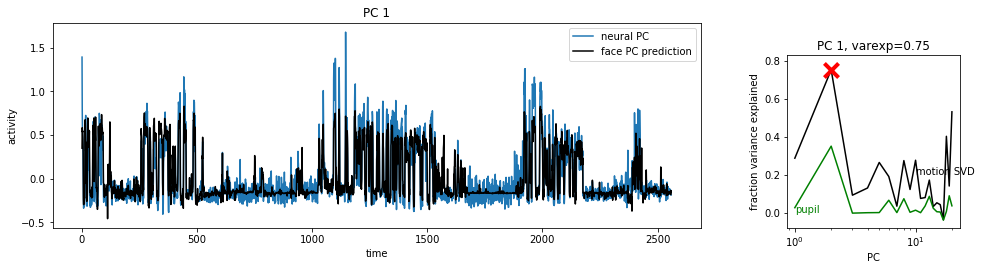

In [17]:
fig=plt.figure(figsize=(12,3))

ipc = 1 ### which PC to plot

ax = fig.add_axes([0.05,.05,.75,.95])
ax.plot(V[ipc,itest], label='neural PC')
ax.plot(Vpred[ipc], color='k', label='face PC prediction')
ax.set_title('PC %d'%ipc)
ax.set_xlabel('time')
ax.set_ylabel('activity')
ax.legend()

ax = fig.add_axes([0.9,.05, .2, .8])
ax.semilogx(np.arange(1,varexp.size+1), varexp, color='k')
ax.scatter(ipc+1, varexp[ipc],marker='x',color='r',s=200, lw=4, zorder=10)
ax.semilogx(np.arange(1,varexp.size+1), varexp_pupil, color=[0.,.5,0])
ax.text(1,0,'pupil',color=[0,.5,0])
ax.text(10,0.2,'motion SVD')
ax.set_xlabel('PC')
ax.set_ylabel('fraction variance explained')
ax.set_title('PC %d, varexp=%0.2f'%(ipc,varexp[ipc]))
plt.show()

In [23]:
print(U.shape)
print(np.nonzero(U[:,0])[0].shape)

(18795, 20)
(1630,)
